Презентация - https://disk.yandex.ru/i/1OrcbAmVKnDhuQ

# ПРОЕКТ
**ВЫЯВЛЕНИЕ ПРОФИЛЕЙ ПОТРЕБИТЕЛЕЙ**

Работа выполняется для интернет-магазина «Пока все ещё тут» с целью проведения рекламных рассылок нужным категориям покупателей.
В процессе работы будет проведена категоризация покупателей, на основе которой будут осуществляться рекламмные рассылки.
Категоризация покупателей будет описывать клиентов в части того, что они покупают, как часто и как много или мало.
Тематика рассылок будет варьироваться в зависимости от сезонности и категории товаров.

**ПЛАН РАБОТЫ**

1. Предобработка данных
    - Изменение типов данных
    - Проверка пропусков
    - поиск и удаление дубликатов (явных и неявных)
    - поиск и удаление аномалий
    - Добавление столбцов
        - месяц покупки
        - день недели покупки
        - сумма покупки
        
        
2. Анализ данных
    - расчет среднего чека по клиенту
    - расчет средней выручки по месяцам
    - расчет количества заказов по месяцам
    - категоризация товаров магазина
    
    
3. Сегментация клиентов методом RFM
    - Сегментация на 27 стандартных групп
    - укрупнение полученных RFM групп
    - выявление связей между сегментами и категориями для выбора таргетной группы для рассылки.


4. Формулировка и проверка статистических гипотез

4.1
    
    H0 - Средний чек покупателя не меняется в зависимости от сегмента
    
    H1 - Средний чек покупателя меняется в зависимости от сегмента
    
4.2    
    
    H0 - Выручка не меняется в зависимости от сегмента

    H1 - Выручка меняется в зависимости от сегмента

5. Подготовка презентации с выводами по проделанной работе   

Табло: https://public.tableau.com/app/profile/sergei.kadochnikov/viz/FinalProjectSK/Dashboard1?publish=yes

In [ ]:
#Импортирую необходимые библиотеки
import pandas as pd
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats as st

In [ ]:
# Загружаю файл дата-сета
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )

## Предобработка данных

In [ ]:
display (df.head(5))
df.info()

### Изменение типов данных
Приводу время к формату datetime, остальные данные выглядят хорошо

In [ ]:
# Привеодим время к приемлимому формату
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d%H')

In [ ]:
df['date'].min()

In [ ]:
df['date'].max()

### Пропуски данных
Прупосков в данных нет.

### Явные и неявные дубликаты
Проверка явных дубликатов - их нет.

In [ ]:
df.duplicated().sum()

Проверка неявных дупликатов.
Предположу, что неяные дубликаты разбросаны по времени, поэтому не буду обращать внимание на дату.

In [ ]:
# Проверка неявных дупликатов
df.duplicated(['customer_id', 'order_id','product', 'price', 'quantity']).sum()

In [ ]:
df=df.drop_duplicates (subset=['customer_id', 'order_id', 'product', 'price', 'quantity'])

Удаляю 1864 неявных дубликата, т.к. один и тот же номер заказ не может иметь разные даты создания.

### Прочие ошибки и аномалии
Проверка соответствия одного номера заказа одному клиенту

In [ ]:
anomiles = df.groupby('order_id').agg({'customer_id' : 'nunique'}
    ).sort_values('customer_id', ascending=False).reset_index(drop=False)

In [ ]:
anomiles=anomiles.query('customer_id > 1 ')
anomiles

Получилось 29 аномальных заказов. Использую список номеров заказа, чтобы удалить все эти заказы из датасета.

In [ ]:
df = df[~df['order_id'].isin(anomiles['order_id'])]

Аномалии по данным: удаляю тестовую запись.

In [ ]:
df['quantity'].describe()
#  Удаляю тестовую запись с 1000 покупок
df = df.query('quantity < 1000')

In [ ]:
len(df)

От первоначального датасета осталось 5543 записи или 74%.  Потеряно даных много, но ошибочные данные не нужны.

### Добавление новых столбцов
В процессе анализа мне понадобятся суммы по каждой позиции, дата с точностью до месяца и сами месяцы.

In [ ]:
df['total'] = df['quantity'] * df['price']
df['dateM'] = df['date'].dt.to_period('M').dt.to_timestamp()
#df['month'] = df['date'].dt.month Оказался ненужным

## Исследовательский анализ

Создаю месячный отчет с указанием номера клиента, нмера заказа и суммы заказа

In [ ]:
sales_report=df.groupby(['dateM', 'customer_id', 'order_id']).agg({'total':'sum'}).reset_index(drop=False)
print(sales_report)

### Выручка за весь период

Сгруппирую данные для удобного вывода

In [ ]:
history = sales_report.groupby('dateM').agg({'total' : 'sum', 'order_id' : 'nunique', 'customer_id' : 'nunique'}).reset_index(drop=False)
history

In [ ]:
history['total']=round(history['total'])

In [ ]:
fig = px.bar(history, x='dateM', y='total', title='Выручка по месяцам', text="total")

fig.update_xaxes(title_text='Месяцы') # подпись для оси X
fig.update_yaxes(title_text='Выручка') # подпись для оси Y
fig.show()

Дела плохи. Выручка падает - видня явная тенденция. Сезон осень-зима 19/20 упал примерно вдвое по аналогичному сезону 18/19

### Количество заказов в месяц за весь период

In [ ]:
fig = px.bar(history, x='dateM', y='order_id', title='Заказы по месяцам', text="order_id")

fig.update_xaxes(title_text='Месяцы') # подпись для оси X
fig.update_yaxes(title_text='Кол-во заказов') # подпись для оси Y
fig.show()

При этом количество заказов в последние месяцы наблюдения имеет усойчивый рост

### Средний чек (весь период)

In [ ]:
# Добавляю столбец среднего чека
history['av_bill']=round(history['total']/history['order_id'],0)
# Добавляю столбец средней выручки с одного клиента
history['sales_cust'] = round(history['total']/history['customer_id'],0)

In [ ]:
fig = px.bar(history, x='dateM', y='av_bill', title='Средний чек по месяцам', text="av_bill")

fig.update_xaxes(title_text='Месяцы') # подпись для оси X
fig.update_yaxes(title_text='Средний чек') # подпись для оси Y
fig.show()

In [ ]:
fig = px.bar(history, x='dateM', y='sales_cust', title='Средняя выручка с клиента', text="sales_cust")

fig.update_xaxes(title_text='Месяцы') # подпись для оси X
fig.update_yaxes(title_text='Средняя выручка') # подпись для оси Y
fig.show()

Падающий тренд виден и в показателях среднего чека / выручки с клиента. Сами графики очень близки, т.к. количество заказов близко к количеству уникальных клиентов.

**ВЫВОДЫ**
Магазин теряет дорогих клиентов, вследствие чего падает средний чек, выручка. При этом видно, что магазин привлекает новых клиентов, число заказов вернулось на уровень периода открытия. Но заказы небольшие.

На графиках выделяются весенние месяцы 2019 - вероятно, это сезонный фактор.

###  Выручка по месяцам

проведу исследование аналогичных метрик по отдельным месяцам.

**ВЫВОД** Получив данные графики и сопоставив с данными за весь период исследования, я пришел к выводу, что рассмотерние данных в рамках месяцев не имеет смысла, т.к. полный период исследования меньше двух лет, и поэтому часть месяцев рассматривается дважды, а часть только один раз, поэтому найти и подтвердить какие-то сезонные паттерны здесь нельзя.

Для дальнейших исследований проведу категоризацию товаров
### Категоризация товаров

Составим словарь товаров и категорий

In [ ]:
category_agenda = {'Щетка' : 'Хоз товары' , 'Агератум' : 'семена и растения' ,
'Адиантум' : 'семена и растения' , 'Азалия' : 'семена и растения' ,'Аквилегия' : 'семена и растения' ,'Алиссум' : 'семена и растения' ,
'Алоэ' : 'семена и растения' ,'Альбука' : 'семена и растения' ,'Амариллис' : 'семена и растения' ,'Анемона' : 'семена и растения' ,
'Антижир' : 'Товары для кухни' ,'Антинакипин' : 'Хоз товары' ,'Антуриум' : 'семена и растения' ,'Аптения' : 'семена и растения' ,
'Арбуз' : 'семена и растения' ,'Аргирантерум' : 'семена и растения' ,'Ароматизированное' : 'Товары для ванной' ,'Артемизия' : 'семена и растения' ,
'Аспарагус' : 'семена и растения' ,'Астра' : 'семена и растения' ,'Афеляндра' : 'семена и растения' ,'Бадан' : 'семена и растения' ,
'Базилик' : 'семена и растения' ,'Бак' : 'Товары для ванной' ,'Баклажан' : 'семена и растения' ,'Бакопа' : 'семена и растения' ,
'Бальзам' : 'семена и растения' ,'Бальзамин' : 'семена и растения' ,'Чехол' : 'Товары для дома' ,'Банка' : 'Товары для кухни' ,
'Набор' : 'Хоз товары' ,'Барвинок' : 'семена и растения' ,'Бархатцы' : 'семена и растения' ,'Бегония' : 'семена и растения' ,
'Бельевые' : 'Хоз товары' ,'Бензин' : 'Хоз товары' ,'Бидон' : 'Хоз товары' ,'Блюдо' : 'Товары для кухни' ,
'Блюдце' : 'Товары для кухни' ,'Буддлея' : 'семена и растения' ,'Бузульник' : 'семена и растения' ,'Бульонница' : 'Товары для кухни' ,
'Ваза' : 'Товары для кухни' ,'Вакуумный' : 'Хоз товары' ,'Валериана' : 'семена и растения' ,'Ванна' : 'Хоз товары' ,
'Вантуз' : 'Хоз товары' ,'Ведро' : 'Хоз товары' ,'Веник' : 'Хоз товары' ,'Венчик' : 'Товары для кухни' ,
'Вербейник' : 'семена и растения' ,'Вербена' : 'семена и растения' ,'Веревка' : 'Хоз товары' ,'Вероника' : 'семена и растения' ,
'Весы' : 'Хоз товары' ,'Сушилка' : 'Хоз товары' ,'Вешалка' : 'Товары для дома' ,'Вешалка-перекладина' : 'Товары для дома' ,
'Вешалка-плечики' : 'Товары для дома' ,'Вешалка-стойка' : 'Товары для дома' ,'Вешалка-сушилка' : 'Товары для дома' ,'Вешалки' : 'Товары для дома' ,
'Вигна' : 'семена и растения' ,'Вилка' : 'Товары для кухни' ,'Виола' : 'семена и растения' ,'Вкладыши' : 'Товары для кухни' ,
'Газания' : 'семена и растения' ,'Гайлардия' : 'семена и растения' ,'Гардения' : 'семена и растения' ,'Гвоздика' : 'семена и растения' ,
'Георгина' : 'семена и растения' ,'Герань' : 'семена и растения' ,'Тележка' : 'Хоз товары' ,'Готовая' : 'Товары для кухни' ,
'Таз' : 'Хоз товары' ,'Стяжка' : 'Хоз товары' ,'Сумка-тележка' : 'Хоз товары' ,'Декоративная' : 'муляжи' ,
'Гербера' : 'семена и растения' ,'Гиацинт' : 'семена и растения' ,'Гимнокалициум' : 'семена и растения' ,'Гиностемма' : 'семена и растения' ,
'Гипоаллергенный' : 'Товары для ванной' ,'Гипсофила' : 'семена и растения' ,'Гладильная' : 'Товары для дома' ,'Искусственный' : 'муляжи' ,
'Светильник' : 'Товары для дома' ,'Салфетка' : 'Товары для кухни' ,'Щетка' : 'Хоз товары' ,'Глоксиния' : 'семена и растения' ,
'Годеция' : 'семена и растения' ,'Горох' : 'семена и растения' ,'Гортензия' : 'семена и растения' ,'Губка' : 'Товары для кухни' ,
'Двуспальное' : 'Товары для дома' ,'Девичий' : 'семена и растения' ,'Декабрист' : 'семена и растения' ,'Рыбочистка' : 'Товары для кухни' ,
'Дендробиум' : 'семена и растения' ,'Сиденье' : 'Хоз товары' ,'Держатель' : 'Товары для ванной' ,'Джункус' : 'семена и растения' ,
'Диффенбахия' : 'семена и растения' ,'Дозатор' : 'Товары для ванной' ,'Доска' : 'Товары для дома' ,'Драцена' : 'семена и растения' ,
'Душица' : 'семена и растения' ,'Дыня' : 'семена и растения' ,'Ель' : 'семена и растения' ,'Емкость' : 'Товары для кухни' ,
'Ёрш' : 'Товары для кухни' ,'Ерш' : 'Товары для ванной' ,'Жестяная' : 'Товары для кухни' ,'Жидкое' : 'Товары для ванной' ,
'Завертка' : 'Хоз товары' ,'Замиокулькас' : 'семена и растения' ,'Запасная' : 'Товары для кухни' ,'Защитная' : 'Товары для кухни' ,
'Защитный' : 'Товары для кухни' ,'Зверобой' : 'семена и растения' ,'Земляника' : 'семена и растения' ,'Змееголовник' : 'семена и растения' ,
'Зубная' : 'Товары для ванной' ,'Измельчитель' : 'Товары для кухни' ,'Измерительный' : 'Хоз товары' ,'Импатиенс' : 'семена и растения' ,
'Искусственная' : 'муляжи' ,'Иссоп' : 'семена и растения' ,'Кабачок' : 'семена и растения' ,'Каланхое' : 'семена и растения' ,
'Калатея' : 'семена и растения' ,'Календула' : 'семена и растения' ,'Калибрахоа' : 'семена и растения' ,'Калла' : 'семена и растения' ,
'Каллуна' : 'семена и растения' ,'Калоцефалус' : 'семена и растения' ,'Камнеломка' : 'семена и растения' ,'Кампанула' : 'семена и растения' ,
'Капсикум' : 'семена и растения' ,'Капуста' : 'семена и растения' ,'Карниз' : 'Товары для ванной' ,'Картофелемялка' : 'Товары для кухни' ,
'Кастрюля' : 'Товары для кухни' ,'Кипарисовик' : 'семена и растения' ,'Кипятильник' : 'Хоз товары' ,
'Клен' : 'семена и растения' ,'Клубника' : 'семена и растения' ,'Ключница' : 'Товары для дома' ,'Ковер' : 'Хоз товары' ,
'Ковёр' : 'Хоз товары' ,'Коврик' : 'Товары для кухни' ,'Фиалка' : 'семена и растения' ,'Ковш' : 'Товары для кухни' ,
'Кодонанта' : 'семена и растения' ,'Колеус' : 'семена и растения' ,'Колокольчик' : 'семена и растения' ,'Кольца' : 'Товары для ванной' ,
'Комнатное' : 'семена и растения' ,'Комод' : 'Товары для дома' ,'Комплект' : 'Товары для ванной' ,'Кондиционер' : 'Товары для ванной' ,
'Контейнер' : 'Хоз товары' ,'Чайник' : 'Товары для кухни' ,'Концентрат' : 'Товары для кухни' ,'Кореопсис' : 'семена и растения' ,
'Корзина' : 'Хоз товары' ,'Корзинка' : 'Хоз товары' ,'Кориандр' : 'семена и растения' ,
'Короб' : 'Хоз товары' ,'Коробка' : 'Товары для ванной' ,'Корыто' : 'Хоз товары' ,'Пробка' : 'Товары для ванной' ,
'Космея' : 'семена и растения' ,'Котел' : 'Хоз товары' ,'Котовник' : 'семена и растения' ,'Кофе' : 'семена и растения' ,
'Кофр' : 'Товары для дома' ,'Крассула' : 'семена и растения' ,'Крепеж' : 'Хоз товары' ,'Крокусы' : 'семена и растения' ,
'Кружка' : 'Товары для кухни' ,'Крышка' : 'Хоз товары' ,'Крючок' : 'Хоз товары' ,'Кувшин' : 'Товары для кухни' ,
'Кухонное' : 'Товары для кухни' ,'Кухонные' : 'Товары для кухни' ,'Лаванда' : 'семена и растения' ,'Лаватера' : 'семена и растения' ,
'Лавр' : 'семена и растения' ,'Лантана' : 'семена и растения' ,'Лапчатка' : 'семена и растения' ,'Левкой' : 'семена и растения' ,
'Лен' : 'семена и растения' ,'Лестница' : 'Хоз товары' ,'Лестница-стремянка' : 'Хоз товары' ,'Лилейник' : 'семена и растения' ,
'Линейка,' : 'Хоз товары' ,'Литопс' : 'семена и растения' ,'Лобелия' : 'семена и растения' ,'Ложка' : 'Товары для кухни' ,
'Лопатка' : 'Товары для кухни' ,'Лоток' : 'Товары для дома' ,'Лук' : 'семена и растения' ,'Львиный' : 'семена и растения' ,
'Любисток' : 'семена и растения' ,'Мантоварка' : 'Товары для кухни' ,'Мантоварка-пароварка' : 'Товары для кухни' ,'Масленка' : 'Товары для кухни' ,
'Маттиола' : 'семена и растения' ,'Махровое' : 'Хоз товары' ,'Махровый' : 'Товары для ванной' ,'Мединилла' : 'семена и растения' ,
'Мелисса' : 'семена и растения' ,'Мерный' : 'Товары для кухни' ,'Мешок' : 'Товары для ванной' ,'Миксер' : 'Товары для кухни' ,
'Мимоза' : 'семена и растения' ,'Мини-сковорода' : 'Товары для кухни' ,'Мирт' : 'семена и растения' ,'Миска' : 'Товары для кухни' ,
'Многолетнее' : 'семена и растения' ,'Модульная' : 'Товары для кухни' ,'Молодило' : 'семена и растения' ,'Монарда' : 'семена и растения' ,
'Морковь' : 'семена и растения' ,'Муляж' : 'муляжи' ,'Муррайя' : 'семена и растения' ,'Мускари' : 'семена и растения' ,
'Мусорный' : 'Товары для дома' ,'Мыло' : 'Товары для ванной' ,'Мыло-скраб' : 'Товары для ванной' ,'Мыльница' : 'Товары для ванной' ,
'Мята' : 'семена и растения' ,'Наволочка' : 'Товары для дома' ,'Наматрасник' : 'Товары для дома' ,'Наматрацник' : 'Товары для дома' ,
'Наматрицник-чехол' : 'Товары для дома' ,'Насадка' : 'Хоз товары' ,'Насадка-моп' : 'Хоз товары' ,'Насадка-отжим' : 'Хоз товары' ,
'Настенная' : 'Хоз товары' ,'Настольная' : 'Товары для дома' ,'Настурция' : 'семена и растения' ,'Незабудка' : 'семена и растения' ,
'Нетканые' : 'Хоз товары' ,'Нефролепис' : 'семена и растения' ,'Нивянник' : 'семена и растения' ,'Новогоднее' : 'семена и растения' ,
'Подрукавник' : 'Товары для дома' ,'Нож' : 'Товары для кухни' ,'Ножеточка' : 'Товары для кухни' ,'Нолина' : 'семена и растения' ,
'Обувница-3' : 'Товары для дома' ,'Овощеварка' : 'Товары для кухни' ,'Овощечистка' : 'Товары для кухни' ,'Овсянница' : 'семена и растения' ,
'Огурец' : 'семена и растения' ,'Одеяло' : 'Товары для дома' ,'Однолетнее' : 'семена и растения' ,'Окномойка' : 'Хоз товары' ,
'Ополаскиватель' : 'Товары для кухни' ,'Орехоколка' : 'Хоз товары' ,'Осина' : 'семена и растения' ,'Основание' : 'Хоз товары' ,
'Отбеливатель' : 'Хоз товары' ,'Отделитель' : 'Товары для кухни' ,'Отжим' : 'Хоз товары' ,'Папоротник' : 'семена и растения' ,
'Паста' : 'Хоз товары' ,'Патиссон' : 'семена и растения' ,'Пахира' : 'семена и растения' ,'Пеларгония' : 'семена и растения' ,
'Кисточка' : 'Товары для кухни' ,'Пена' : 'Товары для ванной' ,'Пеперомия' : 'семена и растения' ,'Перчатки' : 'Хоз товары' ,
'Петля' : 'Хоз товары' ,'Скребок' : 'Хоз товары' ,'Петля-стрела' : 'Хоз товары' ,'Петрушка' : 'семена и растения' ,
'Петуния' : 'семена и растения' ,'Пиретрум' : 'семена и растения' ,'Платикодон' : 'семена и растения' ,'Плед' : 'Товары для дома' ,
'Плечики' : 'Товары для дома' ,'Подарочный' : 'семена и растения' ,'Средство' : 'Хоз товары' ,'Подвесное' : 'семена и растения' ,
'Штора' : 'Товары для ванной' ,'Подголовник' : 'Товары для дома' ,'Подкладка' : 'Товары для дома' ,'Пододеяльник' : 'Товары для дома' ,
'Подсолнечник' : 'семена и растения' ,'Подставка' : 'Товары для кухни' ,'Подушка' : 'Товары для дома' ,'Покрывало' : 'Товары для дома' ,
'Покрытие' : 'Товары для дома' ,'Полка' : 'Товары для дома' ,'Полки' : 'Товары для дома' ,'Половник' : 'Товары для кухни' ,
'Полотенце' : 'Товары для кухни' ,'Портулак' : 'семена и растения' ,'Пресс' : 'Товары для кухни' ,'Примула' : 'семена и растения' ,
'Прищепки' : 'Хоз товары' ,'Просеиватель' : 'Товары для кухни' ,'Простынь' : 'Товары для дома' ,'Простыня' : 'Товары для дома' ,
'Противень' : 'Товары для кухни' ,'Пружина' : 'Хоз товары' ,'Пряные' : 'семена и растения' ,'Пуансетия' : 'семена и растения' ,
'Пуансеттия' : 'семена и растения' ,'Пылесос' : 'Хоз товары' ,'Пьезозажигалка' : 'Хоз товары' ,'Радермахера' : 'семена и растения' ,
'Разделочная' : 'Хоз товары' ,'Ранункулус' : 'семена и растения' ,'Рассада' : 'семена и растения' ,'Рассекатель' : 'Товары для кухни' ,
'Решетка' : 'Хоз товары' ,'Роза' : 'семена и растения' ,'Розмарин' : 'семена и растения' ,'Ролик' : 'Хоз товары' ,
'Рудбекия' : 'семена и растения' ,'Рукав' : 'Товары для дома' ,'Ручка' : 'Хоз товары' ,'Ручка-скоба' : 'Хоз товары' ,
'Салат' : 'семена и растения' ,'Салатник' : 'Товары для кухни' ,'Салфетница' : 'Товары для кухни' ,'Сальвия' : 'семена и растения' ,
'Сантолина' : 'семена и растения' ,'Сахарница' : 'Товары для кухни' ,'Сверло' : 'Хоз товары' ,'Сверло-фреза,' : 'Хоз товары' ,
'Седум' : 'семена и растения' ,'Сельдерей' : 'семена и растения' ,'Сервировочная' : 'Товары для кухни' ,'Сетка' : 'Хоз товары' ,
'Синнингия' : 'семена и растения' ,'Сито' : 'Товары для кухни' ,'Скалка' : 'Товары для кухни' ,'Скатерть' : 'Товары для кухни' ,
'Складная' : 'Товары для дома' ,'Складной' : 'Товары для дома' ,'Сковорода' : 'Товары для кухни' ,'Сменная' : 'Хоз товары' ,
'Сменный' : 'Хоз товары' ,'Сметка' : 'Хоз товары' ,'Смолевка' : 'семена и растения' ,'Совок' : 'Хоз товары' ,
'Соковарка' : 'Товары для кухни' ,'Соковыжималка' : 'Товары для кухни' ,'Соланум' : 'семена и растения' ,'Солидаго' : 'семена и растения' ,
'Сотейник' : 'Товары для кухни' ,'Спатифиллум' : 'семена и растения' ,'Стакан' : 'Товары для ванной' ,'Стеклянная' : 'Товары для кухни' ,
'Стеллаж' : 'Товары для дома' ,'Стиральный' : 'Хоз товары' ,'Столовая' : 'Товары для кухни' ,'Столовый' : 'Товары для кухни' ,
'Стремянка' : 'Хоз товары' ,'Стремянка-табурет' : 'Хоз товары' ,'Стремянки' : 'Хоз товары' ,'Стяжки' : 'Товары для дома' ,
'Суккулент' : 'семена и растения' ,'Сумка' : 'Хоз товары' ,'Многофункциональный' : 'Хоз товары' ,'Шнур' : 'Хоз товары' ,
'Скиммия' : 'семена и растения' ,'Сциндапсус' : 'семена и растения' ,'Тepмокружка' : 'Товары для кухни' ,'Табак' : 'семена и растения' ,
'Тагетис' : 'семена и растения' ,'Тарелка' : 'Товары для кухни' ,'Циперус' : 'семена и растения' ,'Терка' : 'Товары для кухни' ,
'Термокружка' : 'Товары для кухни' ,'Термометр' : 'Хоз товары' ,'Термос' : 'Товары для кухни' ,'Термостакан' : 'Товары для кухни' ,
'Тимьян' : 'семена и растения' ,'Ткань' : 'Хоз товары' ,'Толкушка' : 'Товары для кухни' ,'Томат' : 'семена и растения' ,
'томата' : 'семена и растения' ,'Тортница' : 'Товары для кухни' ,'Тряпка' : 'Хоз товары' ,'Тряпкодержатель' : 'Хоз товары' ,
'Тыква' : 'семена и растения' ,'Тюльпан' : 'семена и растения' ,'Увлажняющая' : 'Товары для ванной' ,'Уголок' : 'Хоз товары' ,
'Укроп' : 'семена и растения' ,'Универсальное' : 'Хоз товары' ,'Универсальный' : 'Товары для кухни' ,'Урна' : 'Хоз товары' ,
'Урна-пепельница' : 'Хоз товары' ,'Утюг' : 'Хоз товары' ,'Фал' : 'Хоз товары' ,'Фаленопсис' : 'семена и растения' ,
'Фарфоровая' : 'Товары для кухни' ,'Фатсия' : 'семена и растения' ,'Фен' : 'Хоз товары' ,'Физостегия' : 'семена и растения' ,
'Фиксатор-шар' : 'Хоз товары' ,'Фикус' : 'семена и растения' ,'Фиттония' : 'семена и растения' ,'Флокс' : 'семена и растения' ,
'Форма' : 'Товары для кухни' ,'Фоторамка' : 'Товары для дома' ,'Фуксия' : 'семена и растения' ,'Халат' : 'Товары для дома' ,
'Хамедорея' : 'семена и растения' ,'Хлебница' : 'Товары для кухни' ,'Хлорофитум' : 'семена и растения' ,'Холодная' : 'Хоз товары' ,
'Хоста' : 'семена и растения' ,'Хризантема' : 'семена и растения' ,'Хризолидокарпус' : 'семена и растения' ,'Цветок' : 'муляжи' ,
'Цветущее' : 'семена и растения' ,'Целозия' : 'семена и растения' ,'Цикламен' : 'семена и растения' ,'Цикламен,' : 'семена и растения' ,
'Цинерания' : 'семена и растения' ,'Цинерария' : 'семена и растения' ,'Циния' : 'семена и растения' ,'Цинния' : 'семена и растения' ,
'Цитрофортунелла' : 'семена и растения' ,'Чабер' : 'семена и растения' ,'Чайная' : 'Товары для кухни' ,'Чайный' : 'Товары для кухни' ,
'Чистящий' : 'Хоз товары' ,'Шалфей' : 'семена и растения' ,'Швабра' : 'Хоз товары' ,'Шеффлера' : 'семена и растения' ,
'Шило' : 'Хоз товары' ,'Шпагат' : 'Хоз товары' ,'Шпингалет' : 'Хоз товары' ,'Шприц' : 'Товары для кухни' ,
'Штанга' : 'Товары для ванной' ,'Штангенциркуль' : 'Хоз товары' ,'Щётка' : 'Хоз товары' ,'Щетка-сметка' : 'Хоз товары' ,
'Щетка-утюжок' : 'Хоз товары' ,'Эвкалипт' : 'семена и растения' ,'Электроштопор' : 'Товары для кухни' ,'Энотера' : 'семена и растения' ,
'Эпипремнум' : 'семена и растения' ,'Этажерка' : 'Товары для дома' ,'Эхеверия' : 'семена и растения' ,'Эхинацея' : 'семена и растения' ,
'Эхинокактус' : 'семена и растения' ,'Эшшольция' : 'семена и растения' ,'Юкка' : 'семена и растения' ,'Ясколка' : 'семена и растения' ,
'Ящик' : 'Хоз товары'}

Добавляем категорию товара в датасет с использованием функции.

In [ ]:
def assign_category(text):
    for word, category in category_agenda.items():
        if word in text:
            return category
    return None

# Create a new column 'Category' based on the dictionary values
df['Category'] = df['product'].apply(assign_category)
df.head(5)

In [ ]:
category_chart = df. groupby('Category').agg({'product' : 'nunique'}).reset_index(drop=False)
category_chart
fig = go.Figure(data=[go.Pie(labels=category_chart['Category'], values=category_chart['product'])])

fig.update_layout(
    title="Распределение товарных позиций по категориям"
    )
fig.show()

In [ ]:
category_chart = df. groupby('Category').agg({'total' : 'sum'}).reset_index(drop=False)
category_chart
fig = go.Figure(data=[go.Pie(labels=category_chart['Category'], values=category_chart['total'])])

fig.update_layout(
    title="Распределение продаж по категориям"
    )
fig.show()

## Сегментация покупателей

Сегментацию проведу методом RFM-анализа

### Сегментирование

In [ ]:
#Фиксирую дату последней покупки
now = df['date'].max()

Создаю таблицу RFM значений

In [ ]:
RFM_table=df.groupby('customer_id').agg({'date': lambda x: (now - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'total': lambda x: x.sum()}).reset_index(drop=False)

In [ ]:
RFM_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                         'total': 'monetary_value'}, inplace=True)
RFM_table = RFM_table.sort_values(by = 'monetary_value')
RFM_table.tail()

Сделаю разбивку каждого параметра на три диапазона. Итоговое число RFM-групп будет 27

In [ ]:
quantiles = RFM_table.quantile(q=[0.33,0.66])
quantiles

In [ ]:
quantiles = quantiles.to_dict()
RFM_Segment = RFM_table.copy()

def R_Class(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
    
def FM_Class(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3

In [ ]:
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [ ]:
#Проверю список самых ценных клиентов
RFM_Segment[RFM_Segment['RFMClass']=='113'].sort_values('frequency', ascending=False)

### Укрупнение сегментов
Проведу укрупнение  категорий до 3.
В данном количестве групп хочу рассмотреть базовое разделение по группе М

In [ ]:
segment_agenda = {'333': 'Сегмент 1', '233': 'Сегмент 1', '133': 'Сегмент 1', '323': 'Сегмент 1',
                  '223': 'Сегмент 1', '123': 'Сегмент 1', '313': 'Сегмент 1', '213': 'Сегмент 1',
                  '113': 'Сегмент 1', '332': 'Сегмент 2', '232': 'Сегмент 2', '132': 'Сегмент 2',
                  '322': 'Сегмент 2', '222': 'Сегмент 2', '122': 'Сегмент 2', '312': 'Сегмент 2',
                  '212': 'Сегмент 2', '112': 'Сегмент 2', '331': 'Сегмент 3', '231': 'Сегмент 3',
                  '131': 'Сегмент 3', '321': 'Сегмент 3', '221': 'Сегмент 3', '121': 'Сегмент 3',
                  '311': 'Сегмент 3', '211': 'Сегмент 3', '111': 'Сегмент 3'}

Полученный словарь применяю к таблице RFM-сегментов и переношу столбец Сегментов в основной датафрейм.

In [ ]:
RFM_Segment['Segment'] = RFM_Segment['RFMClass'].map(segment_agenda)
RFM_Segment.head(5)

Добавляю столбец с Сегментами в общий датафрейм

In [ ]:
df = pd.merge(df, RFM_Segment[['customer_id', 'Segment']], on='customer_id', how='left')

In [ ]:
segment_chart = df. groupby('Segment').agg({'customer_id' : 'nunique', 'total' : 'sum', 'quantity' : 'sum', 'order_id' : 'nunique'}).reset_index(drop=False)
segment_chart['цена'] = round(segment_chart['total']/segment_chart['quantity'],0)
segment_chart['mean'] = round(segment_chart['total']/segment_chart['customer_id'],0)
segment_chart['frq'] = round(segment_chart['order_id']/segment_chart['customer_id'],2)
segment_chart['quantity'] = round(segment_chart['quantity']/segment_chart['order_id'],2)
segment_chart = segment_chart.rename(columns={'customer_id' : 'Кол-во клиентов','quantity' : 'Кол-во товаров' })
display(segment_chart)

<div class="alert alert-block alert-info">
  
  <b>Комментарий cтудента</b>
  Разделение на сегменты получилось практически равномерное.
    
  При разделение клиентов с акцентом на Monetary я ожидал явных различий по деньгам.
    
    В первом ценном сегменте средняя выручка с клиента 3692р, он совершает в среднем 1.7 заказа, покупая 5,9 единиц товара со средней ценой 365р
    
    Покупатели второго сегмента совершают 1,38 заказов на сумму в 4 раза меньшую, чем покупатели Сегмента 1. Они покупают более деешвый товар в 2 раза меньшем количестве.
    
    Покупатели Сегмента 3 по выручке так же сильно отстают от С-2, как С-2 от С-1, разница более чем в 3 раза. При этом меньшее количество заказов на человека - 1.24 и меньшее число единиц товарв - в среднем 2 шт по 106 рублей. Каждый четверый покупатель совершает вторую покупку.
</div>

Сегментирование завершено.

### Выявление связей между группами и сегментами

In [ ]:
df.head(5)

Рассмотрим взаимосвязь по выручке и по количеству заказов

In [ ]:
cat_seg = df.groupby(['Segment', 'Category'], as_index = False)[['total']].sum()

In [ ]:
display(cat_seg)

In [ ]:
# используем стиль dark из библиотеки seaborn
sns.set_style('dark')
# назначаем размер графика
plt.figure(figsize=(15, 6))
# строим столбчатый график средствами seaborn
sns.barplot(x='Segment', y='total', data=cat_seg, hue='Category')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Выручка по сегментам и категориям')
plt.xlabel('сегменты')
plt.ylabel('Выручка')
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

In [ ]:
cat_seg2 = df.groupby(['Segment', 'Category'], as_index = False)[['order_id']].nunique()

In [ ]:
cat_seg2

In [ ]:
# используем стиль dark из библиотеки seaborn
sns.set_style('dark')
# назначаем размер графика
plt.figure(figsize=(15, 8))
# строим столбчатый график средствами seaborn
sns.barplot(x='Segment', y='order_id', data=cat_seg2, hue='Category')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Количество заказов по категориям в сегментах')
plt.ylabel('Заказы')
plt.xlabel('сегменты')
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='upper right', fontsize=10)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

Выводы по двум графикам:
1. Для сегмента 1 я вижу потенциал роста в товарах для кухни, т.к. количество заказов сопоставимо с аналогичной категорией в других сегментах, в то время как товары для дома и хоз.товары ы первом сегменте продаются чаще. Постоянные денежные покупатели могут отрыть для себя что-то новое в этой категории магазина.
2. Второму сегменту надо напомнить о себе и сделать акцент на хоз.товарах, спровоцировать на дополнительные покупки акциями вида "4=3", т.к. по количеству заказов в категории отставание от первого сегмента всего на треть, а вот в денежном выражении - в 5 раз меньше. 
3. Третий сегмент покупает в основном растения и семена, возможно раз в год. Надо использовать покупателей семян и цветов для продажи остального ассортимента, например давать купон на скидку на товры других категорий.

Рассмотрим ранее полученный график выручки по времени с разбивкой на сегменты

In [ ]:
history

In [ ]:
stat_tot = df.groupby(['dateM', 'Segment']).agg({'total' : 'sum', 'order_id' : 'nunique', 'customer_id' : 'nunique'}).reset_index(drop=False)
stat_tot = pd.merge(history, stat_tot, left_on = 'dateM', right_on = 'dateM', how = 'left')
stat_tot['ratio'] = round(stat_tot['total_y'] / stat_tot['total_x']*100,1)
stat_tot = stat_tot.rename(columns={'total_y': 'в Сегменте', 'total_x': 'Всего'})
stat_tot.head(5)

In [ ]:
stat_tot = df.groupby(['dateM', 'Segment']).agg({'total' : 'sum', 'order_id' : 'nunique', 'customer_id' : 'nunique'}).reset_index(drop=False)
stat_tot = pd.merge(history, stat_tot, left_on = 'dateM', right_on = 'dateM', how = 'left')
stat_tot['ratio'] = round(stat_tot['total_y'] / stat_tot['total_x']*100,1)
stat_tot = stat_tot.rename(columns={'total_y': 'в Сегменте', 'total_x': 'Всего'})
stat_tot.head(5)

# Строим график
fig = px.bar(stat_tot, x='dateM', y='ratio', hover_data=['Всего', 'в Сегменте'], color='Segment')
fig.update_layout(title='Доли выручки в сегментах по времени', xaxis_title='Месяцы', yaxis_title='Доля сегмента')
fig.update_xaxes(tickangle=45)
fig.show()

**ВЫВОД**
Магазин крайне зависим от денежных клиентов, которые приносят ему 80% выручки. Надо наращивать второй сегмент, чтобы сократить риски. Изменение поведения одного крупного клиента может серьезно повлиять на метрики магазина.

In [ ]:
stat_tot = df.groupby(['dateM', 'Category']).agg({'total' : 'sum', 'order_id' : 'nunique', 'customer_id' : 'nunique'}).reset_index(drop=False)
stat_tot = pd.merge(history, stat_tot, left_on = 'dateM', right_on = 'dateM', how = 'left')
stat_tot['ratio'] = round(stat_tot['total_y'] / stat_tot['total_x']*100,1)
stat_tot = stat_tot.rename(columns={'total_y': 'в категории', 'total_x': 'Всего'})
stat_tot.head(6)
# Строим график
fig = px.bar(stat_tot, x='dateM', y='в категории', hover_data=['Всего', 'в категории'], color='Category')
fig.update_layout(title='Доли выручки в категориях по времени', xaxis_title='Месяцы', yaxis_title='Доля Категории')
#fig.update_xaxes(tickangle=45)
fig.show()

**Вывод**
В течение года хоз.товары пользуются постоянным спросом. Про сезонность говорить затруднительно - мало данных по времени, а в ноябре 2019 случилсяпровал продаж в этой категории, не подтвердив паттерн прошлого года.

Фактор сезонности можно увидеть в Семенах и саженцах - с марта по май виден явеый рос, оепнчивающийся сезоном посадки. Как я говорил выше, фактор семян надо применить для продаж в других категориях. Клиенты вероятно сами придут, поэтому их стоит предупредить о прекрасной возможности приобрести что-то вместе с семенами со скидкой.

In [ ]:
#построим график продаж товаров в количественном выражении а разрезе категорий по месяцам
df.query('Segment =="Сегмент 1"').pivot_table(index=['dateM'], columns = 'Category', values='order_id', aggfunc='nunique')\
.plot(grid=True, figsize=(15, 8), title = 'Количество заказов, оформленных клиентами 1 Сегмента по категориям  в месяц')
plt.xlabel('Месяцы')
plt.ylabel('Выручка по категориям')
plt.show()

Сегмент 1.
    
    Хоз.товары - главная категория товаров для Сегмента 1. Исключая первые месяцы наблюдения, котоые вероятно подогревались хорошими скидками в расчете на привлечение клиентов, мы видим, что хоз.товары обычно продавались 30-40 раз в месяц. В мае-июне 2019 года объем заказов упал в двое от локального максимума. Два месяца - это уже не случайность, поэтому в 2020 году имеет смысл запустить акцию по данной группе товаров для самых лояльных клиентов.
    
    Семена и саженцы имеют четкие сезонные паттерны и вряд ли получится в августе сентябре увеличить продажи в этой категории, но покупателем растений надо будет в 2020 году предложить дополнительную скидку на товары для ванны и для кухни до конца лета, чтобы подтолкнуть продажи отстающих категорий.

In [ ]:
#построим график продаж товаров в количественном выражении а разрезе категорий по месяцам
df.query('Segment =="Сегмент 2"').pivot_table(index=['dateM'], columns = 'Category', values='order_id', aggfunc='nunique')\
.plot(grid=True, figsize=(15, 8), title = 'Количество заказов, оформленных клиентами 2 Сегмента по категориям  в месяц')
plt.xlabel('Месяцы')
plt.ylabel('Выручка по категориям')
plt.show()


Сегмент 2.
    
    Семена и растения  будут иметьявные сезонные паттерны в любом сегменте, поэтому приток клиентов весной за семенами и саженцами, и в холодный период за компантными растениями стоит использовать как инстурмент увеличения среднего чека, предлагая при покупке растений скидку на товары для дома, кухни и ванны.
    
    В целом для покупателей второго сегмента виденно падение по всем категориям в мае без улучшения ситуации в июне. Для этого сегмента можно ввести акцию типа 2=3 (или 3=4). Такие акции стимулируют брать товары, близкие по цене, для получения максимальной скидки.
    
    В расчете на цикличность необходимо отдельно простимулировать товары для кухни в Апреле-июне независимо от покупателей семян и саженцев.

In [ ]:
#построим график продаж товаров в количественном выражении а разрезе категорий по месяцам
df.query('Segment =="Сегмент 3"').pivot_table(index=['dateM'], columns = 'Category', values='order_id', aggfunc='nunique')\
.plot(grid=True, figsize=(15, 8), title = 'Количество заказов, оформленных клиентами 3 Сегмента по категориям  в месяц')
plt.xlabel('Месяцы')
plt.ylabel('Выручка по категориям')
plt.show()

   
Сегмент 3.
    
    В среднем редкий клиент Сегмента 3 оставляет в магазине около 270 рублей. Сложно будет от него ожидать покупку на 1000.
    Как и со вторым сегментом мы дожны использовать интерес к семенам и саженцам для продажи остальных категорий, которые продаются примерно одинаково.
    
    Сегмент 3 так же можно привлекать скидками в праздничные дни. Месяцы с праздниками - это провал для магазина. Благо, что данный сегмент составляет дает около 5 выручки и такие падения не столь ощутимы. 

<div class="alert alert-block alert-info">
    
</div>

**Семена и растения** (41% ассортимент, 15% выручка) - Катеогрия имеет явный сезонный паттерн в период с февраля по май. Причем в Сегменте 1 (С-1) пик приходитсмя на май, в С-2 - на апрель, а в С-3 - на февраль.
Второй акцент - ноябрь-январь, где наблюдается хорошой рост. Для С-1 и С-2 стоит активиизровать усилия начиная с сентября (август может быть не эффективным из-за сезонеа отпусков)

**Хоз.товары** (24%/46%) - главная категория магазина, приносящая 46% выручки. Категория лишена выраженных годовых паттернов. Товар продается ровно во всех сегментах

**Товары для кухни** (14,7% / 11,7%). В С-2 Товары для кухни проваливаются в весенне-летний период - стоит сконцентрировать усилия и вернуть уровень заказвов на привычный по году уровень. В С-1 и С-3 Куходнные товаря продаются стабильно.

**Товары для дома** (10.6% / 19,8%) Категория продается в С-1 и С-2 стабильно, в С-3 есть провал в весенне-летнем сезоне, после чего продажи возвращаются на упривычный ровень. Вероятно, многие клиенты уезжают на дачу и перестают заказывать. Таким клиентам после покупки семян и саженцев можно выслать купон на скидку, со сроком действия до конца лета, чтобы поднять продажи в сезоне

**Товары для ванной** (4.7; / 4.5%) - Продажи данной категории иногда  останаливаются. Возможно стоит проанализировать ассортимент отдельно и расширить его.

## Проверка гипотез
### Гипотеза 1

H0 - Средний чек покупателя не меняется в зависимости от сегмента

H1 - Средний чек покупателя меняется в зависимости от сегмента

Выделим датафреймы для каждого сегмента

In [ ]:
#  формируем срез для каждого сенгмента по сумме заказов 
df1 = df.query('Segment == "Сегмент 1"').groupby(['customer_id', 'order_id']
            ).agg({'total':'sum'}).reset_index()
df2 = df.query('Segment == "Сегмент 2"').groupby(['customer_id', 'order_id']
            ).agg({'total':'sum'}).reset_index()
df3 = df.query('Segment == "Сегмент 3"').groupby(['customer_id', 'order_id']
            ).agg({'total':'sum'}).reset_index()

Проверка средних по Шапиро-Уилка

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(df1['total'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(df2['total'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(df3['total'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

Распределения и втором сегменте ненормаьные. Для сравнения групп применю непараметрический тест Манна-Уитни

In [ ]:
results = st.mannwhitneyu(df1['total'], df2['total'])
n = 3 # количество тестов для вычисления поправки

alpha = 0.05/(n-1)

# вывод значения p-value на экран
print('p-значение: ', results.pvalue)

#условный оператор с выводом строки с ответом
if alpha > results.pvalue:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

In [ ]:
results = st.mannwhitneyu(df2['total'], df3['total'])
n = 3 # количество тестов для вычисления поправки

alpha = 0.05/(n-1)

# вывод значения p-value на экран
print('p-значение: ', results.pvalue)

#условный оператор с выводом строки с ответом
if alpha > results.pvalue:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

In [ ]:
results = st.mannwhitneyu(df1['total'], df3['total'])
n = 3 # количество тестов для вычисления поправки

alpha = 0.05/(n-1)

# вывод значения p-value на экран
print('p-значение: ', results.pvalue)

#условный оператор с выводом строки с ответом
if alpha > results.pvalue:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

### Вторая статистическая гипотеза:

H0 - Среднее число заказов не меняется в зависимости от сегмента

H1 - Среднее число заказов меняется в зависимости от сегмента

    
  Проверка средних по Шапиро-Уилка

In [ ]:
df11 = df.query('Segment == "Сегмент 1"').groupby(['customer_id']
            ).agg({'order_id':'nunique'}).reset_index()
df22 = df.query('Segment == "Сегмент 2"').groupby(['customer_id']
            ).agg({'order_id':'nunique'}).reset_index()
df33 = df.query('Segment == "Сегмент 3"').groupby(['customer_id']
            ).agg({'order_id':'nunique'}).reset_index()

In [ ]:
results = st.shapiro(df11['order_id'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

In [ ]:
results = st.shapiro(df22['order_id'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

In [ ]:
results = st.shapiro(df33['order_id'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

Такие маленькие p-значения говорят о том, что данные во всех трех выборках значительно отклоняются от нормального распределения. Мы можем отвергнуть нулевую гипотезу о нормальности данных на основе этого p-значения.

Поэтому для проверки гипотез снова будем использовать непараметрический критерий Манна-Уитни. Возьмем alpha = 0.05.

In [ ]:
results = st.mannwhitneyu(df11['order_id'], df22['order_id'])

alpha = 0.05/(n-1)

# вывод значения p-value на экран
print (results.pvalue)

#условный оператор с выводом строки с ответом
if alpha > results.pvalue:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

In [ ]:
results = st.mannwhitneyu(df22['order_id'], df33['order_id'])

alpha = 0.05/(n-1)

# вывод значения p-value на экран
print (results.pvalue)

#условный оператор с выводом строки с ответом
if alpha > results.pvalue:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

In [ ]:
results = st.mannwhitneyu(df11['order_id'], df33['order_id'])

alpha = 0.05/(n-1)

# вывод значения p-value на экран
print (results.pvalue)

#условный оператор с выводом строки с ответом
if alpha > results.pvalue:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

**ВЫВОД**
H1 - Среднее число заказов меняется в зависимости от сегмента

Проверю, как ведут себя исследуемые в гипотезах значения.

In [ ]:
plt.figure(figsize=(12, 8))    
sns.kdeplot(data=df1['total'], label='Сегмент 1')   
sns.kdeplot(data=df2['total'], label='Сегмент 2')
sns.kdeplot(data=df3['total'], label='Сегмент 3')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))    
sns.kdeplot(data=df11['order_id'], label='Сегмент 1')   
sns.kdeplot(data=df22['order_id'], label='Сегмент 2')
sns.kdeplot(data=df33['order_id'], label='Сегмент 3')
plt.legend()
plt.xlim([0, 10])
plt.show()

Предварительный отчет. 

## Выводы

### Анализ исходных данных
Для подготовки рекомендаций по рассылкам поокупателям был проведен анализ полученных данных.
В ходе первичного анализа были обнаружены многочисленные задвоения заказов с разными датами - таких данных 24%.
Так же были обнаружены заказы, относязиеся сразу к нескольким клиентским номерам.
Заказчику необходимо проверить корректность создания своих отчетов по продажам.

При непосредственном исследовании данных б ыла проведена сегментация покупателей по трем группам с акцентом на размер выручки.
Товарный ассортимент был категоризован. В дальнейшем рекомендую отправлять данные по продажам вместе с категоризацией данных - так вы сможете более четко анализировать продажи круппных групп товаров.

### Анализ продаж

Был проведен помесячный анализ продаж за весь исследуемый период.
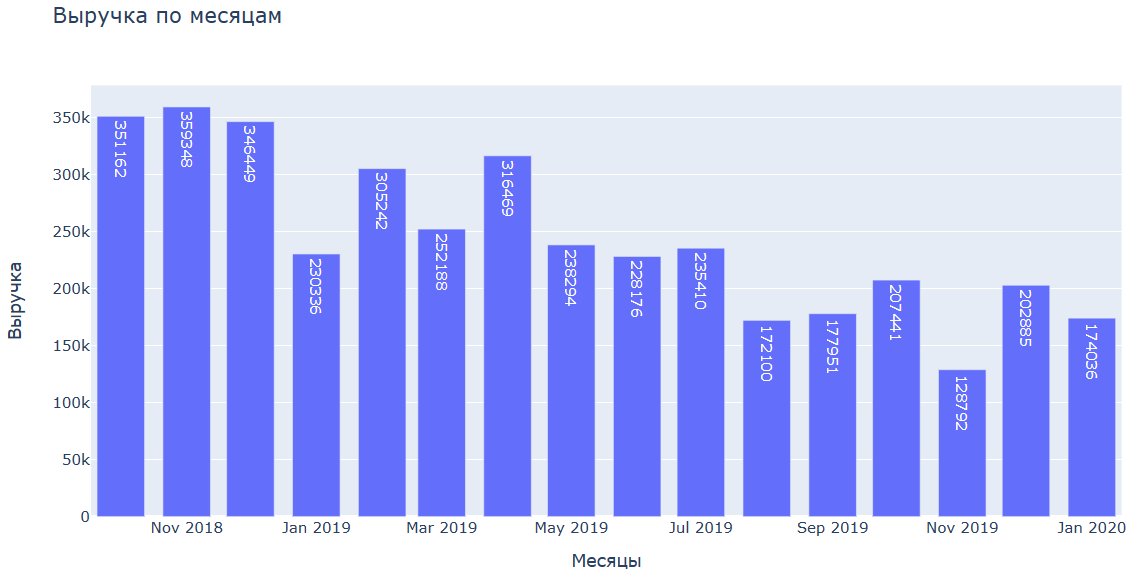

Дела плохи. Выручка падает - видня явная тенденция. Сезон осень-зима 19/20 упал примерно вдвое по аналогичному сезону 18/19.

Кроме того, анализ сегментов показал критически большую долю крупных клиентов в клиентской базе

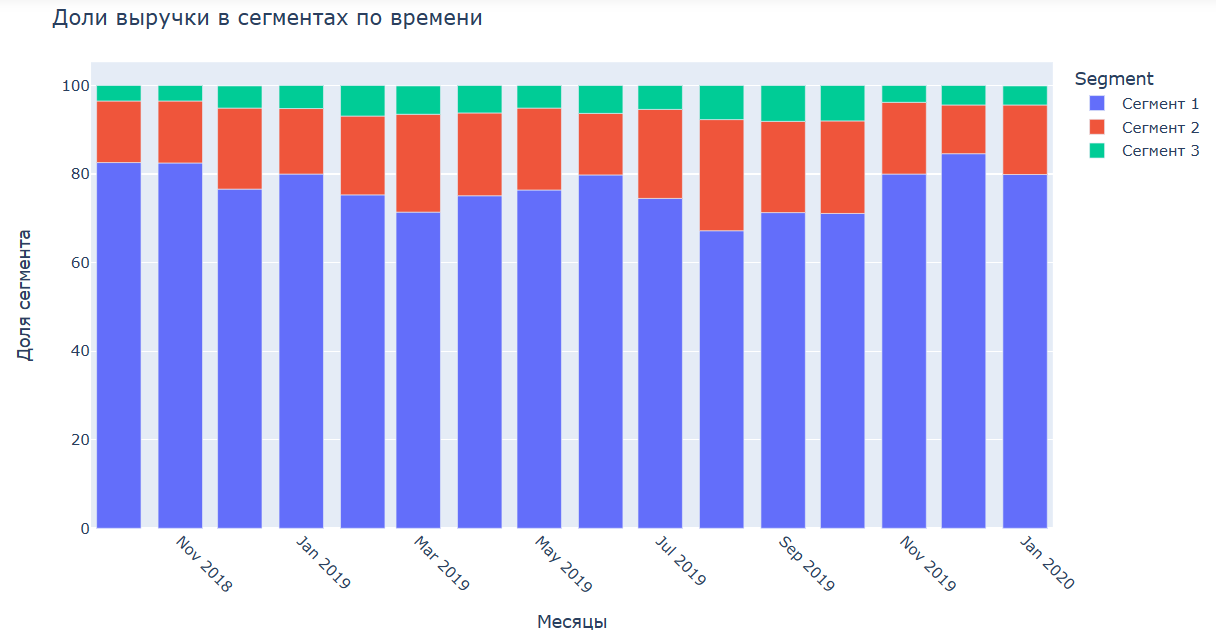

Магазин крайне зависим от денежных клиентов, которые приносят ему 80% выручки. Надо наращивать второй сегмент, чтобы сократить риски. Изменение поведения одного крупного клиента может серьезно повлиять на метрики магазина.

Так же негативные результаты дал анализ среднего чека - за год средний чек упал почти в 3 раза.
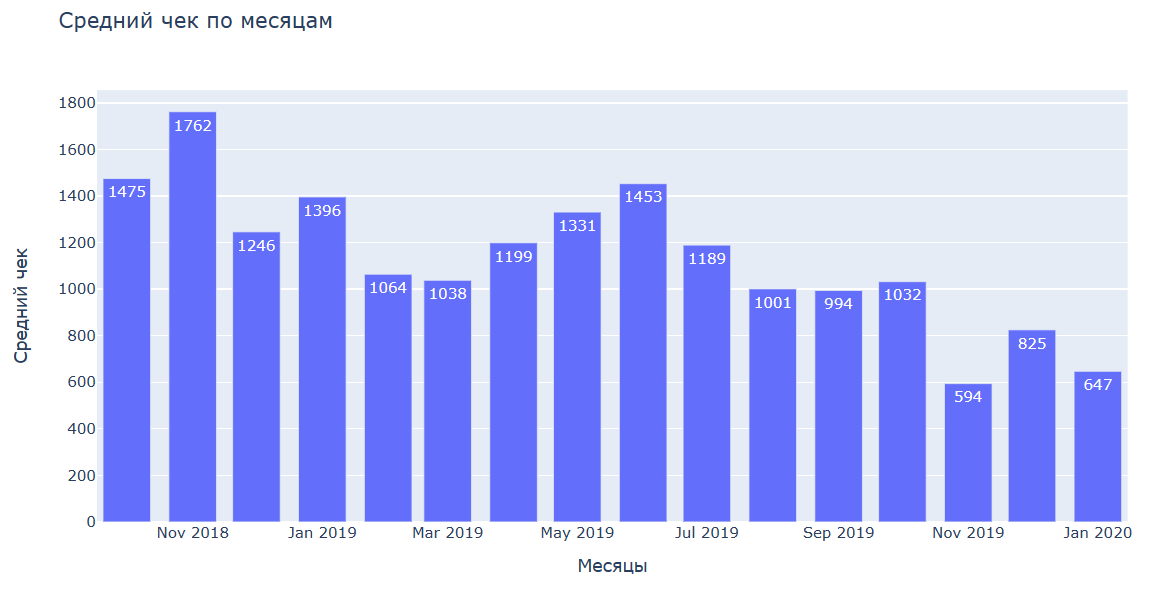

При этом в последние месяцы наблюдается рост количества заказов
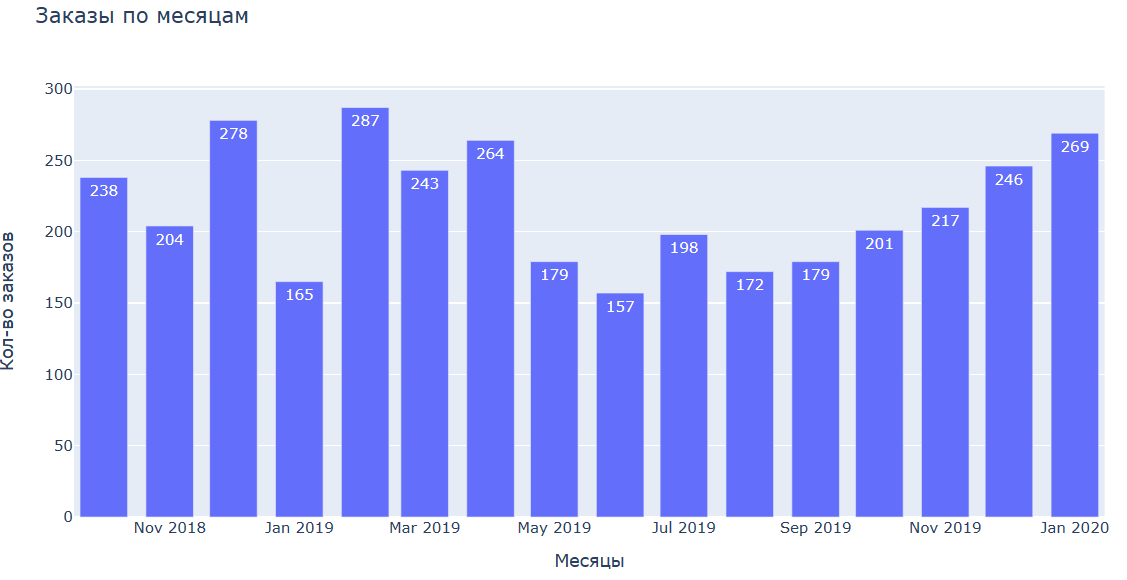

Клиенты к вам идут - надо подталкивать их покупать большое!

### Анализ клиентских сегментов и товарных категорий

  Разделение на сегменты получилось практически равномерное.
    
  При разделение клиентов с акцентом на Monetary я ожидал явных различий по выручке.
    
    В первом ценном сегменте средняя выручка с клиента 3692р, он совершает в среднем 1.7 заказа, покупая 5,9 единиц товара со средней ценой 365р
    
    Покупатели второго сегмента совершают 1,38 заказов на сумму в 4 раза меньшую, чем покупатели Сегмента 1. Они покупают более деешвый товар в 2 раза меньшем количестве.
    
    Покупатели Сегмента 3 по выручке так же сильно отстают от С-2, как С-2 от С-1, разница более чем в 3 раза. При этом меньшее количество заказов на человека - 1.24 и меньшее число единиц товарв - в среднем 2 шт по 106 рублей. Каждый четверый покупатель совершает вторую покупку.

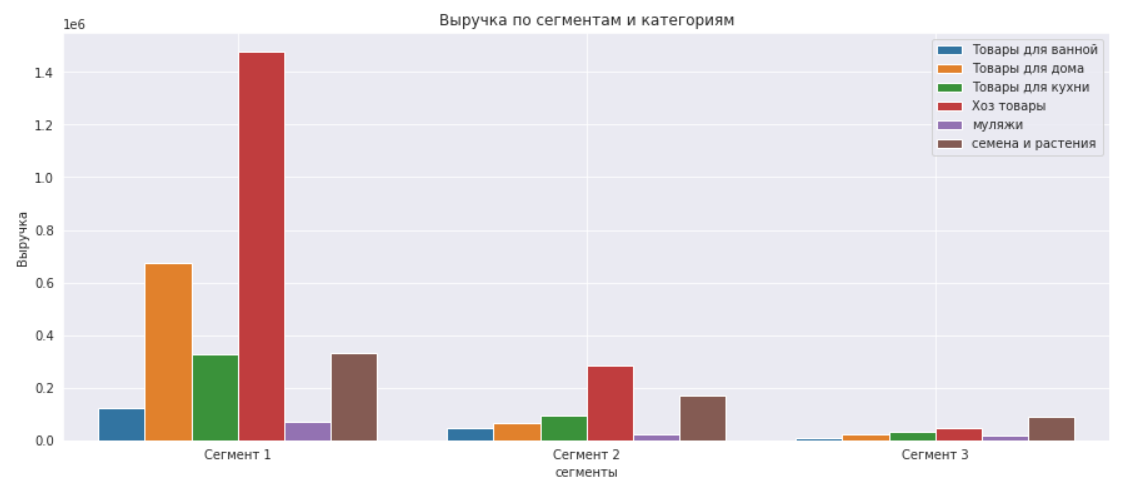

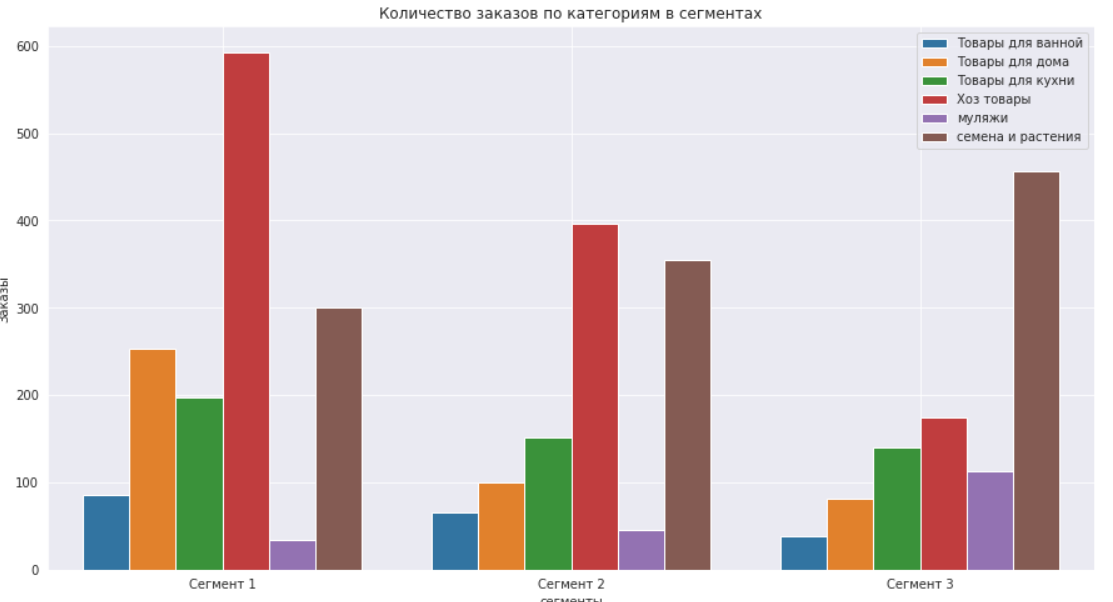

<div class="alert alert-block alert-info">
  
  
    
Сегмент 1.
    
    Хоз.товары - главная категория товаров для Сегмента 1. Исключая первые месяцы наблюдения, котоые вероятно подогревались хорошими скидками в расчете на привлечение клиентов, мы видим, что хоз.товары обычно продавались 30-40 раз в месяц. В мае-июне 2019 года объем заказов упал в двое от локального максимума. Два месяца - это уже не случайность, поэтому в 2020 году имеет смысл запустить акцию по данной группе товаров для самых лояльных клиентов.
    
    Семена и саженцы имеют четкие сезонные паттерны и вряд ли получится в августе сентябре увеличить продажи в этой категории, но покупателем растений надо будет в 2020 году предложить дополнительную скидку на товары для ванны и для кухни до конца лета, чтобы подтолкнуть продажи отстающих категорий.



Сегмент 2.
    
    Семена и растения  будут иметьявные сезонные паттерны в любом сегменте, поэтому приток клиентов весной за семенами и саженцами, и в холодный период за компантными растениями стоит использовать как инстурмент увеличения среднего чека, предлагая при покупке растений скидку на товары для дома, кухни и ванны.
    
    В целом для покупателей второго сегмента виденно падение по всем категориям в мае без улучшения ситуации в июне. Для этого сегмента можно ввести акцию типа 2=3 (или 3=4). Такие акции стимулируют брать товары, близкие по цене, для получения максимальной скидки.
    
    В расчете на цикличность необходимо отдельно простимулировать товары для кухни в Апреле-июне независимо от покупателей семян и саженцев.



Сегмент 3.
    
    В среднем редкий клиент Сегмента 3 оставляет в магазине около 270 рублей. Сложно будет от него ожидать покупку на 1000.
        Как и со вторым сегментом мы дожны использовать интерес к семенам и саженцам для продажи остальных категорий, которые продаются примерно одинаково. Новым покупателям после совершения покупки семян выдается купон (бумажный, если оффлайн, электронный, если онлайн). Для прошлогодних покупателей купон можно поместить в личный кабинет или в корзину при наличии нужных товаров в корзине и соответствующего номера телефона. Рассылка не нужна.
    
    Сегмент 3 так же можно привлекать скидками в праздничные дни. Месяцы с праздниками - это провал для магазина. Благо, что данный сегмент дает около 5 выручки и такие падения не столь ощутимы. Вопрос о экономической целесообразности акции - на усмотрение маркетолога.


</div>


Вернемся к графику продаж, но с учетом категорий товаров 
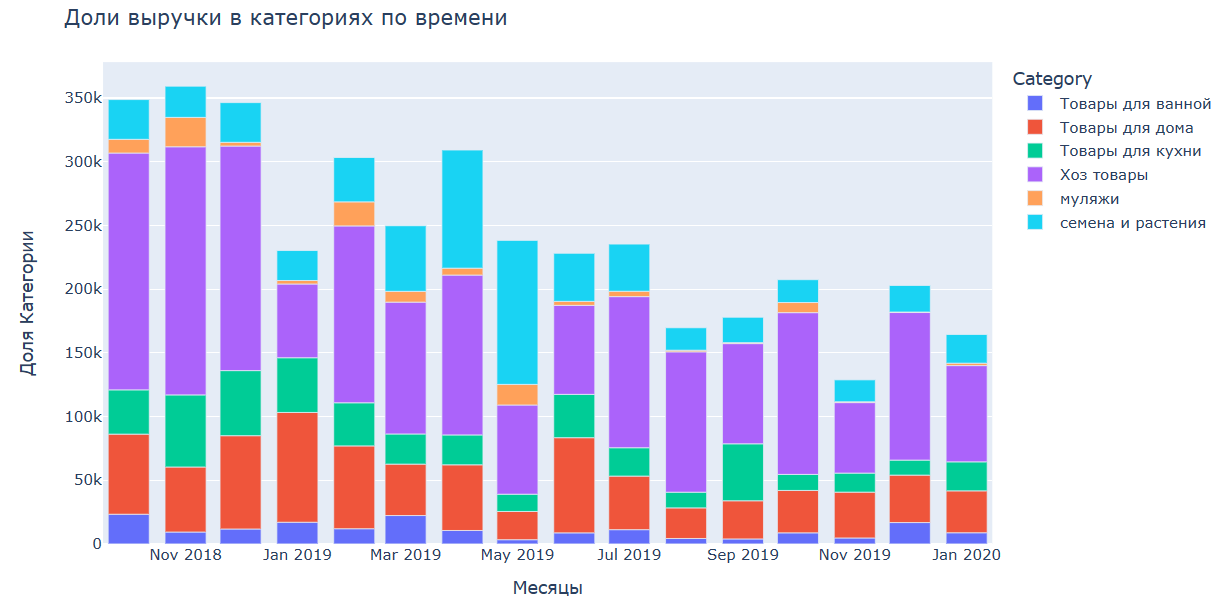

В течение года хоз.товары пользуются постоянным спросом. Про сезонность говорить затруднительно - мало данных по времени, а в ноябре 2019 случилсяпровал продаж в этой категории, не подтвердив паттерн прошлого года.

Фактор сезонности можно увидеть в Семенах и саженцах - с марта по май виден явеый рос, оепнчивающийся сезоном посадки. Как я говорил выше, фактор семян надо применить для продаж в других категориях, особенно в Сегменте 3. Клиенты вероятно сами придут, поэтому их стоит предупредить о прекрасной возможности приобрести что-то вместе с семенами со скидкой. Так же можно предложить скидку на следующую покупку в 2-3 категориях (Товары для дома, ванны кухни)

### Статистические гипотезы

Сегментация клиентов была проверена  двумя гипотезами о различии среднего чека и среднего количества заказов между сегментами. Статистический анализ подтвердил различия между сегментами покупателей, что говорит о корректности разделения для поставленной задачи.